# Solving Allen-Cahn Equation using SA-PINN

## Problem Setup

(see https://youtu.be/UTC6cccEEnM?t=267)

Allen-Cahn equation for two-phase microstructrue evolution:

$$\left\{\begin{array}{l}u_t - 0.00001u_{xx} + 5u^3 - 5u = 0 \quad x\in[-1,1], t \in [0,1] \newline
u(x, 0) = x^2 \cos(\pi x) \newline
u(-1, t) = u(1, t) \newline
u_x(-1, t) = u_x(1, t)
\end{array}
\right.$$



## Install and Import Libraries

In [1]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
from pyDOE import lhs

# eager_lbfgs from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py
from eager_lbfgs import lbfgs, Struct

### Check GPU Status

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10208925030720965402
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14385217536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18386936142505564166
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Import Dataset and Process

In [4]:
# data from https://github.com/levimcclenny/SA-PINNs
data = scipy.io.loadmat('AC.mat')

In [5]:
x = data['x'].flatten() # 512: [-1, 1]
t = data['tt'].flatten() # 201: [0, 1]
usol = data['uu'] # exact solution at 512 x 201 (x, t) grid

X, T = np.meshgrid(x, t)

In [6]:
## Test set

X_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) # (102912, 2)

lb = X_u_test[0] # [-1, 0]
ub = X_u_test[-1] # [1, 1]

u = usol.flatten('F')[:, None] #(102912, 1)

In [7]:
np.random.seed(1234)
tf.random.set_seed(1234)

## Training set

N0 = 512 # IC
N_b = 100 # BC
N_f = 20000


# IC(t = 0, x in [-1, 1])
idx_ic = np.random.choice(x.shape[0], N0, replace=False) # choose `N0` points from total 512 points
X0_train = np.hstack((X[0, :][:, None], T[0, :][:, None]))[idx_ic, :]
u0_train = usol[idx_ic, 0][:, None]

# BCs(x = +1 or -1, t in [0, 1])
idx_bc = np.random.choice(t.shape[0], N_b // 2, replace=False) # choose `N_b` points from total 201 points
bottom_x_train = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))[idx_bc, :]
top_x_train = np.hstack((X[:, -1][:, None], T[:, 0][:, None]))[idx_bc, :]

# Collocation Points(PDE)
# Latin Hypercube sampling for collocation points
X_f_train = lb + (ub - lb) * lhs(2, N_f)
# X_f_train = np.vstack([X_f_train, X0_train, bottom_x_train, top_x_train]) # concatenate all training sets

# change them into tensorflow tensors
X0_train = tf.Variable(X0_train, dtype='float32')
u0_train = tf.Variable(u0_train, dtype='float32')
bottom_x_train = tf.Variable(bottom_x_train, dtype='float32')
top_x_train = tf.Variable(top_x_train, dtype='float32')
X_f_train = tf.Variable(X_f_train, dtype='float32')

## Define SA-PINN Model

In [13]:
# When I was learning SA-PINN from https://github.com/levimcclenny/SA-PINNs
# I found that training with Keras model is much faster than training with my custom model (in previous example)
# So I use Keras model in this example

def build_NN(layer_sizes):
    """
    Return a Keras model, which will be our SA-PINN model
    """

    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0], )))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"
        ))
    model.add(layers.Dense(
        layer_sizes[-1], activation=None,
        kernel_initializer="glorot_normal"
    ))

    return model

@tf.function
def u_x(model, X):
    """
    Return u and u_x at dataset X.

    Just for conviniently calculating loss_BC
    """

    x = X[:, 0:1]
    t = X[:, 1:2]

    # tf.stack([x[:, 0], t[:, 0]], axis=1) <=> z 

    u = model(tf.stack([x[:, 0], t[:, 0]], axis=1))
    u_x = tf.gradients(u, x)

    return u, u_x

@tf.function
def f_model(model, X_f_train):
    """
    return residual of pde

    params:
      model: a Keras model
      X_f_train: PDE training set 
    """
    x_f = X_f_train[:, 0:1]
    t_f = X_f_train[:, 1:2]


    # tf.stack([x_f[:, 0], t_f[:, 0]], axis=1) <=> X_f_train
    # It's been destructured then stacked because we need the gradients of x and t  
    u = model(tf.stack([x_f[:, 0], t_f[:, 0]], axis=1))
    u_x = tf.gradients(u, x_f)
    u_xx = tf.gradients(u_x, x_f)
    u_t = tf.gradients(u, t_f)    

    # f: residual of pde
    c1 = tf.constant(0.0001, dtype=tf.float32)
    c2 = tf.constant(5.0, dtype=tf.float32)
    f = u_t - c1*u_xx + c2*u*u*u - c2*u

    return f


def loss_IC(model, X0_train, u0_train, ic_weights):
    """
    Calculate the loss score of initial condition

    Params:
        model: a Keras model
        X0_train: training set of initial condition
        u0_train: exact `u` value at the IC training set (since we have the data of `u`, we can use part of it to train model)
        ic_weights: adaptive weights of IC
    """

    # element-wise multiply by adaptive weights of boundary
    loss0 = ic_weights * (tf.math.subtract(u0_train, model(X0_train)))
    loss0 = tf.reduce_mean(tf.square(loss0))
    return loss0

def loss_BC(model, bottom_x_train, top_x_train):
    """
    Calculate the loss score of boundary condition

    Params: 
        model: a Keras model
        bottom_x_train, top_x_train: training set of boundary condition
    """

    bottom_u_pred, bottom_u_x_pred = u_x(model, bottom_x_train)
    top_u_pred, top_u_x_pred = u_x(model, top_x_train)

    loss_u = tf.reduce_mean(tf.square(tf.math.subtract(bottom_u_pred, top_u_pred))) + tf.reduce_mean(tf.square(tf.math.subtract(bottom_u_x_pred, top_u_x_pred)))

    return loss_u

def loss_PDE(model, X_f_train, f_weights):
    """
    Calculate the loss score of PDE

    Params: 
      model: a Keras model
      X_f_train: trainning set of PDE as well as BC/IC (I've concatenated them above)
      f_weights: adaptive weights of residual of PDE
    """

    f = f_model(model, X_f_train) # residual of PDE
    # element-wise multiply by adaptive weights of residual
    loss_f = tf.reduce_mean(tf.square(f_weights * f))

    return loss_f

def loss(model, X0_train, u0_train, bottom_x_train, top_x_train, X_f_train, ic_weights, f_weights):
    """
    Calculate total loss of the model

    Params:
        model: a Keras model
        X0_train: training set of initial condition
        u0_train: exact `u` value at the IC training set (since we have the data of `u`, we can use part of it to train model)
        bottom_x_train, top_x_train: training set of boundary condition
        X_f_train: trainning set of PDE as well as BC/IC
        ic_weights, f_weights: adaptive weights of IC, PDE

    return: 
      loss_val: total loss
      loss0: loss of IC
      loss_u: loss of boundary
      loss_f: loss of pde(residual)
    """

    loss0 = loss_IC(model, X0_train, u0_train, ic_weights)
    loss_u = loss_BC(model, bottom_x_train, top_x_train)
    loss_f = loss_PDE(model, X_f_train, f_weights)

    loss_val = loss0 + loss_u + loss_f

    return loss_val, loss0, loss_u, loss_f

@tf.function
def adaptive_gradients(model, X0_train, u0_train, bottom_x_train, top_x_train, X_f_train, ic_weights, f_weights):
    """
    Calculate model weights' gradients, as well as adaptive weights' gradients

    Params:
        model: a Keras model
        X0_train: training set of initial condition
        u0_train: exact `u` value at the IC training set (since we have the data of `u`, we can use part of it to train model)
        bottom_x_train, top_x_train: training set of boundary condition
        X_f_train: trainning set of PDE as well as BC/IC
        ic_weights, f_weights: adaptive weights of IC, PDE

    return:
        loss_val: total loss
        gradients: grads of Keras model's weights and bias
        gradient_ic_weight, gradient_f_weight: grads of adaptive weights
    """
    with tf.GradientTape(persistent=True) as tape:
        loss_val, loss0, loss_u, loss_f = loss(model, X0_train, u0_train, bottom_x_train, top_x_train, X_f_train, ic_weights, f_weights)
    # gradients of model's weights
    gradients = tape.gradient(loss_val, model.trainable_variables) 
    # gradients of adaptive weights
    gradient_ic_weights = tape.gradient(loss_val, ic_weights)
    gradient_f_weights = tape.gradient(loss_val, f_weights)

    del tape

    return loss_val, gradients, gradient_ic_weights, gradient_f_weights

def get_weights(model):
    """
    Return a 'long' tensor of model weights' current value

    params:
      model: a keras model
    """

    long_weights_tensor = []

    for layer in model.layers:
        layer_weights = layer.get_weights()
        # flatten weights and biases
        w_1d = tf.reshape(layer_weights[0], [-1])
        b_1d = tf.reshape(layer_weights[1], [-1])

        # then concatenate them into a single tensor
        long_weights_tensor = tf.concat([long_weights_tensor, w_1d], axis=0)
        long_weights_tensor = tf.concat([long_weights_tensor, b_1d], axis=0)

    return long_weights_tensor

def set_weights(parameters):
    """
    Set model weights, given new weights values(stored in parameters)

    IMPORTANT: 
      In this function, `model` isn't an argument.
      You have to build a Keras model called `model`: model = build_NN(layer_sizes)
      Or you have to rename `model` in this function to you own model's name

    Params:
       parameters: a "long" tensor of new model weights, whose size and shape fit `long_weights_tensor` defined in get_weights(model)
     """

    # Since `parameters` is a long tensor, we have to destructure it to update model weights.
    # To do that, we need shape and size of each weight and bias

    for layer in model.layers:
        layer_weights = layer.get_weights()
        w_shape = tf.shape(layer_weights[0]).numpy()
        w_size = tf.size(layer_weights[0]).numpy()

        # pick new weight in `parameters`
        new_w = parameters[0:w_size]
        new_w = tf.reshape(new_w, w_shape)
        parameters = np.delete(parameters, np.arange(w_size), axis=0) # delete this part from `parameters`, so we can get next bias from index 0

        b_shape = tf.shape(layer_weights[1]).numpy()
        b_size = tf.size(layer_weights[1]).numpy()

        # pick new bias in `parameters`
        new_b = parameters[0:b_size]
        new_b = tf.reshape(new_b, b_shape)
        parameters = np.delete(parameters, np.arange(b_size), axis=0) # delete this part from `parameters`, so we can get next weight from index 0

        new_weights = [new_w, new_b]
        layer.set_weights(new_weights)


def optimizer_func(parameters):
    """
    Define an optimizer function for scipy's l-bfgs optimizer

    IMPORTANT: 
      In this function, `model` isn't an argument.
      You have to build a Keras model called `model`: model = build_NN(layer_sizes)
      Or you have to rename `model` in this function to you own model's name

    Params:
        parameters: a "long" tensor of new model weights, whose size and shape fit `long_weights_tensor` defined in self.get_weights()

    Returns:
        loss.numpy(): loss score of the model
        gradients_1d.numpy(): a numpy array of gradients
    """

    set_weights(parameters) # set new weights

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
            
        # loss after update
        loss_val, loss0, loss_u, loss_f = loss(model, X0_train, u0_train, bottom_x_train, top_x_train, X_f_train, ic_weights, f_weights)

        gradients = tape.gradient(loss_val, model.trainable_variables)

        del tape

        gradients_1d = [] # flatten gradients, like `long_weights_tensor` defined in self.get_weights()

        for g in gradients:
            gradients_1d = tf.concat([gradients_1d, tf.reshape(g, [-1])], 0) 

        return loss_val, gradients_1d


def train_model(model, X0_train, u0_train, bottom_x_train, top_x_train,
                X_f_train, ic_weights, f_weights,
                adam_epochs, lbfgs_epochs):
    """
    Train the model.

    Params:
        model: a Keras model
        X0_train: training set of initial condition
        u0_train: exact `u` value at the IC training set (since we have the data of `u`, we can use part of it to train model)
        bottom_x_train, top_x_train: training set of boundary condition
        X_f_train: trainning set of PDE as well as BC/IC
        ic_weights, f_weights: adaptive weights of IC, PDE
        adam_epochs: epochs of Adam training
        lbfgs_epochs: epochs of L-BFGS training
    """

    # firstly, use Tensorflow Adam optimizer to apply gradient descent/ascent
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9)
    optimizer_adaptive_weights = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9)

    print("Starting Adam training")

    for epoch in range(adam_epochs):

        loss_val, gradients, gradient_ic_weights, gradient_f_weights = adaptive_gradients(model, X0_train, u0_train, bottom_x_train, top_x_train, X_f_train, ic_weights, f_weights)

        if (epoch+1) % 10 == 0:
            print(f"epoch: {epoch+1} loss: {loss_val.numpy():.5f}")

        # apply gradient descent on model weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # apply gradient ascent on adaptive weights
        optimizer_adaptive_weights.apply_gradients(zip([-gradient_ic_weights, -gradient_f_weights], [ic_weights, f_weights]))

    # then, use scipy l-bfgs optimizer to train 
    print("Starting L-BFGS training")
    lbfgs(optimizer_func,
      get_weights(model),
      Struct(), maxIter=lbfgs_epochs, learningRate=0.8)

## Train the Model

In [15]:
layer_sizes = [2, 128, 128, 128, 128, 1]
ic_weights = tf.Variable(100*tf.random.uniform([N0, 1]), trainable=True, name='ic_weight')
f_weights = tf.Variable(tf.random.uniform([N_f, 1]), trainable=True, name='pde_weight')
model = build_NN(layer_sizes)

adam_epochs = 10000
lbfgs_epochs = 10000

train_model(model, X0_train, u0_train, bottom_x_train, top_x_train,
            X_f_train, ic_weights, f_weights,
            adam_epochs, lbfgs_epochs)

Starting Adam training
epoch: 10 loss: 714.66595
epoch: 20 loss: 482.75040
epoch: 30 loss: 375.34698
epoch: 40 loss: 360.53506
epoch: 50 loss: 325.80011
epoch: 60 loss: 179.21478
epoch: 70 loss: 79.17467
epoch: 80 loss: 226.69859
epoch: 90 loss: 67.05071
epoch: 100 loss: 60.35109
epoch: 110 loss: 54.29002
epoch: 120 loss: 50.14162
epoch: 130 loss: 47.30705
epoch: 140 loss: 43.18798
epoch: 150 loss: 38.96521
epoch: 160 loss: 33.96938
epoch: 170 loss: 28.13353
epoch: 180 loss: 21.37192
epoch: 190 loss: 14.60303
epoch: 200 loss: 11.13436
epoch: 210 loss: 125.83408
epoch: 220 loss: 42.88947
epoch: 230 loss: 21.56494
epoch: 240 loss: 14.02147
epoch: 250 loss: 8.52440
epoch: 260 loss: 6.49801
epoch: 270 loss: 5.45149
epoch: 280 loss: 4.70089
epoch: 290 loss: 102.09795
epoch: 300 loss: 22.76059
epoch: 310 loss: 6.57094
epoch: 320 loss: 4.77848
epoch: 330 loss: 4.32202
epoch: 340 loss: 4.39389
epoch: 350 loss: 4.16397
epoch: 360 loss: 4.14976
epoch: 370 loss: 4.15416
epoch: 380 loss: 4.19686
e

## Print and Plot the Model

In [16]:
# L2 error of the model
u_pred = model(X_u_test).numpy()
L2_error = np.linalg.norm((u - u_pred), 2) / np.linalg.norm(u, 2)
print(f'Test set L2 error: {L2_error:5f}')

Test set L2 error: 0.030337


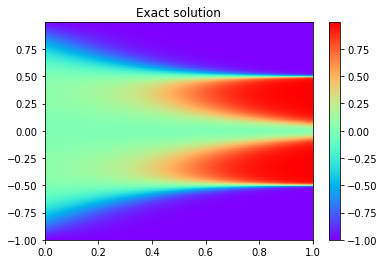

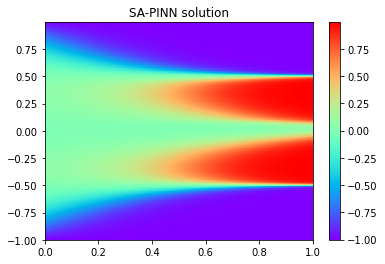

In [31]:
# plot the exact solution
plt.figure()
plt.imshow(usol, interpolation='nearest', cmap='rainbow',
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
plt.title('Exact solution')
plt.colorbar()
plt.show()
plt.close()


u_pred = model(X_u_test).numpy().reshape((x.shape[0], t.shape[0]), order='F')
plt.figure()
plt.imshow(u_pred, interpolation='nearest', cmap='rainbow',
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
plt.title('SA-PINN solution')
plt.colorbar()
plt.show()
plt.close()

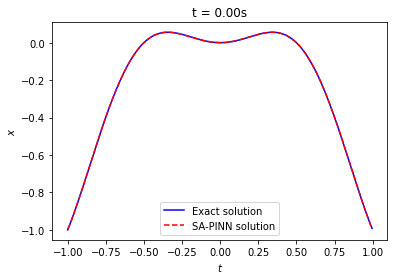

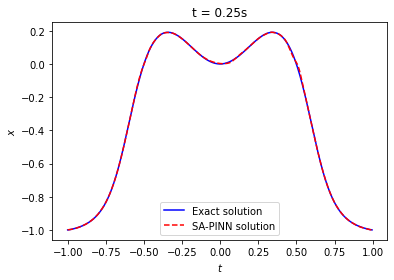

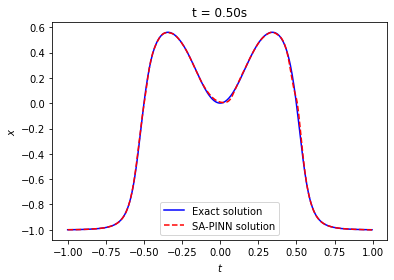

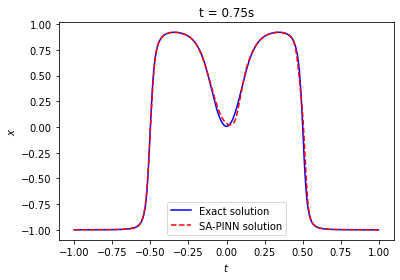

In [33]:
idx_lst = [0, 50, 100, 150]

for idx in idx_lst:
    plt.figure()
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    plt.plot(x, usol[:,idx], 'b-', label='Exact solution')
    plt.plot(x, u_pred[:,idx], 'r--', label='SA-PINN solution')
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(f't = {t[idx]:.2f}s')
    plt.legend()

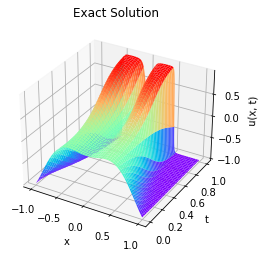

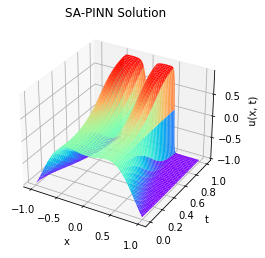

In [19]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, u.reshape((201, 512)), cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('Exact Solution')
plt.show()

ax = plt.axes(projection='3d')
ax.plot_surface(X, T, u_pred.T, cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('SA-PINN Solution')
plt.show()

## Save Model

**Important: You have to use the same dataset as the above dataset to import and use this saved model. Other datasets will cause error and will cause inacurate result.**

Data to save:

- model's layers => layers (use layers to initialize model)
- model's weights => sa_pinn.get_weights()  (use SA_PINN.set_weight() to set new model's weights)
- model's adaptive weights => sa_pinn.u_weights, sa_pinn.f_weights

In [25]:
import json

data_dict = {
    "layers": layer_sizes,
    "model_weights": get_weights(model).numpy().tolist(),
    "model_adaptive_weights": [ic_weights.numpy().tolist(), f_weights.numpy().tolist()]
}

data_json = json.dumps(data_dict, indent=4)

with open('SAPINNmodel.json', 'w') as f:
    f.write(data_json)

## Load Model

Load model from previously saved model. (See **Save Model below**)

In [27]:
import json

def build_NN(layer_sizes):
    """
    Return a Keras model, which will be our SA-PINN model
    """

    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0], )))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"
        ))
    model.add(layers.Dense(
        layer_sizes[-1], activation=None,
        kernel_initializer="glorot_normal"
    ))

    return model

def set_weights(model, parameters):
    """
    Set model weights, given new weights values(stored in parameters)

    Params:
       model: a Keras model
       parameters: a "long" tensor of new model weights, whose size and shape fit `long_weights_tensor` defined in get_weights(model)
     """

    # Since `parameters` is a long tensor, we have to destructure it to update model weights.
    # To do that, we need shape and size of each weight and bias

    for layer in model.layers:
        layer_weights = layer.get_weights()
        w_shape = tf.shape(layer_weights[0]).numpy()
        w_size = tf.size(layer_weights[0]).numpy()

        # pick new weight in `parameters`
        new_w = parameters[0:w_size]
        new_w = tf.reshape(new_w, w_shape)
        parameters = np.delete(parameters, np.arange(w_size), axis=0) # delete this part from `parameters`, so we can get next bias from index 0

        b_shape = tf.shape(layer_weights[1]).numpy()
        b_size = tf.size(layer_weights[1]).numpy()

        # pick new bias in `parameters`
        new_b = parameters[0:b_size]
        new_b = tf.reshape(new_b, b_shape)
        parameters = np.delete(parameters, np.arange(b_size), axis=0) # delete this part from `parameters`, so we can get next weight from index 0

        new_weights = [new_w, new_b]
        layer.set_weights(new_weights)

def load_model(model_path):
    """
    return an trained SA-PINN model for burgers equation
    
    params:
      model_path: path of json file that contains model's data
    """
    
    with open(model_path, 'r') as f:
        model_data = json.load(f)
        f.close()
    
    # data
    layers = model_data['layers']
    model_weights = np.array(model_data['model_weights'])
    model_adaptive_weights = model_data['model_adaptive_weights']

    model =  build_NN(layers) 
    set_weights(model, model_weights)
    ic_weights = tf.convert_to_tensor(model_adaptive_weights[0])
    f_weights = tf.convert_to_tensor(model_adaptive_weights[1])
    
    return model, ic_weights, f_weights

In [ ]:
model_path = 'models/SAPINNmodel.json' # your model path

model, ic_weights, f_weights = load_model(model_path)